# <span style="color:#0b486b">  FIT3181/5215: Deep Learning (2025)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **A/Prof Zongyuan Ge** | zongyuan.ge@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
 <br/>
*Head Tutor 3181:*  **Ms Ruda Nie H** |  \[RudaNie.H@monash.edu \] <br/>
*Head Tutor 5215:*  **Ms Leila Mahmoodi** |  \[leila.mahmoodi@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

## <span style="color:#0b486b">Tutorial 06a: Advanced Convolutional Neural Networks</span> ##

**The purpose of this tutorial is to show you how to implement ResNet, the most popular CNN model. This ResNet implementation follows the original paper of ResNet.**


**Acknowledgement:** *This tutorial is developed based on the material in chapter 7 of the book Dive Into Deep Learning*.

**References and additional reading and resources**
- Chapter 7 of Dive Into Deep Learning ([link](https://d2l.ai/chapter_convolutional-modern/index.html)).

**Hint**: The implementations of ResNet in this tutorial would facilitate you in doing Part 3 of assignment 1.


## <span style="color:#0b486b">I. Implementation of Residual Network (ResNet)</span> <span style="color:red">*****</span> ##
This is a **highly recommend-to-learn** knowledge because ResNet is the most widely popular architecture used in computer vision tasks. Moreover, we can apply what is learned here to assignment 1.  

### <span style="color:#0b486b">I.1. Residual Block</span> ###

The building block of ResNet is the **residual block** which has the following architecture: *[CONV2D, BatchNorm, RELU, CONV2D, BatchNorm]* together with the skip connection. For the skip connection, we have two options: `use 1x1 CONV1D` or `not use 1x1 CONV1D`. The following figure shows the architecture of the residual block for two options.

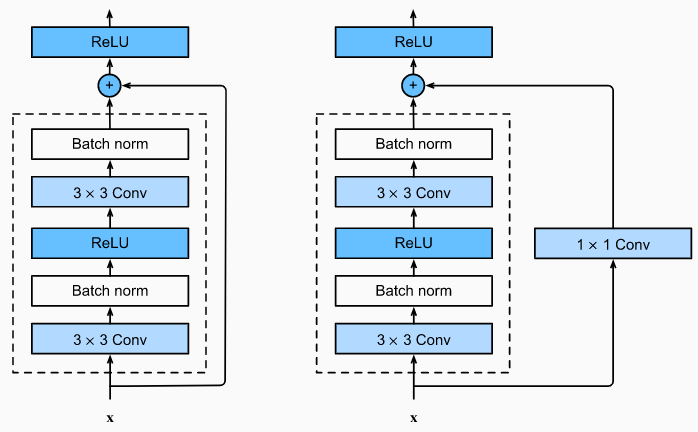

In what follows, we are going to implement the class `Residual`.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU()

    def forward(self, X):
      Y = self.relu(self.bn1(self.conv1(X)))
      Y = self.bn2(self.conv2(Y))
      if self.conv3 is not None:
        X = self.conv3(X)
      Y += X
      return self.relu(Y)

Consider the case when we do not apply 1x1 Conv1D, hence it requires the `num_channels` is equal to the `input_depth` (equal to 3 in the following example).

In [ ]:
blk = Residual(3)
X = torch.rand((4, 3, 6, 6))
Y = blk(X)
print(Y.shape)

torch.Size([4, 3, 6, 6])


If we apply 1x1 Conv1D, the output shape of the residual block can be different from the input shape.

In [ ]:
blk = Residual(num_channels=3, use_1x1conv=False, strides=1)
X = torch.rand((10, 3, 32, 32))
Y = blk(X)
print(Y.shape)

torch.Size([10, 3, 32, 32])


In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
X = torch.rand((10, 3, 32, 32))
Y = blk(X)
print(Y.shape)

torch.Size([10, 6, 16, 16])


### <span style="color:#0b486b">I.2. ResNet Block</span> ###

We now implement **ResNet block**. A ResNet block consists of several residual blocks and we need to declare the number of residual blocks as `num_residuals` and the common number of channels of residual blocks in a ResNet block as `num_channels`.

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, num_channels, num_residuals, first_block=False, **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))
        self.residual_blk = nn.ModuleList(self.residual_layers)

    def forward(self, X):
        for layer in self.residual_blk:
            X = layer(X)
        return X

Note that from the second ResNet block, we apply `1x1 Conv1D` over the skip connection of every first residual block.

### <span style="color:#0b486b">I.3. Residual Network</span> ###

We now declare our ResNet. Note that we set `input_shape = [28,28,1]` because we will train our ResNet on Fashion MNIST dataset.

In [ ]:
class create_ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.ModuleList([
                  nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                  nn.LazyBatchNorm2d(),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                  ResnetBlock(64, 2, first_block=True),
                  ResnetBlock(128, 2),
                  ResnetBlock(256, 2),
                  nn.AdaptiveAvgPool2d((1, 1)),
                  nn.Flatten(1),
                  nn.LazyLinear(10),
                  # nn.Softmax(dim=-1)
                  ])
  def forward(self, X):
    for _, layer in enumerate(self.layers):
      X = layer(X)
    return X


We feed a batch $X$ with batch size $1$ to our ResNet and print out the output shapes. Your task is to explain the results.

In [ ]:
X = torch.rand(size=(1, 1, 28, 28))
for _, layer in enumerate(create_ResNet().layers):
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', list(X.shape))

Conv2d output shape:	 [1, 64, 14, 14]
BatchNorm2d output shape:	 [1, 64, 14, 14]
ReLU output shape:	 [1, 64, 14, 14]
MaxPool2d output shape:	 [1, 64, 7, 7]
ResnetBlock output shape:	 [1, 64, 7, 7]
ResnetBlock output shape:	 [1, 128, 4, 4]
ResnetBlock output shape:	 [1, 256, 2, 2]
AdaptiveAvgPool2d output shape:	 [1, 256, 1, 1]
Flatten output shape:	 [1, 256]
Linear output shape:	 [1, 10]


### <span style="color:#0b486b">I.4. Test our ResNet</span> ###

In [ ]:
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

train_set, valid_set = torch.utils.data.random_split(train_set, [50000, 10000], generator=torch.Generator().manual_seed(42))
print("Traing set\n\t-Number of samples:\t{}\n\t-Shape of 1 sample:\t{}".format(len(train_set), list(train_set[0][0].shape)))
print("Valid set\n\t-Number of samples:\t{}\n\t-Shape of 1 sample:\t{}".format(len(valid_set), list(valid_set[0][0].shape)))
print("Test set\n\t-Number of samples:\t{}\n\t-Shape of 1 sample:\t{}".format(len(test_set), list(test_set[0][0].shape)))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64)

100%|██████████| 26421880/26421880 [00:02<00:00, 12722561.31it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205806.17it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 1052348.73it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20389307.83it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Traing set
	-Number of samples:	50000
	-Shape of 1 sample:	[1, 28, 28]
Valid set
	-Number of samples:	10000
	-Shape of 1 sample:	[1, 28, 28]
Test set
	-Number of samples:	10000
	-Shape of 1 sample:	[1, 28, 28]


In [ ]:
class BaseTrainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader):
        self.model = model
        self.criterion = criterion  #the loss function
        self.optimizer = optimizer  #the optimizer
        self.train_loader = train_loader  #the train loader
        self.val_loader = val_loader  #the valid loader
        self.stop_training = False

    #the function to train the model in many epochs
    def fit(self, num_epochs):
        self.num_batches = len(self.train_loader)

        for epoch in range(num_epochs):
            if self.stop_training:
                break
            print(f'Epoch {epoch + 1}/{num_epochs}')

            train_loss, train_accuracy = self.train_one_epoch()
            val_loss, val_accuracy = self.validate_one_epoch()
            print(
                f'{self.num_batches}/{self.num_batches} - loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}'
            )

    #train in one epoch
    def train_one_epoch(self):
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0

        for i, data in enumerate(self.train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = correct / total
        train_loss = running_loss / self.num_batches
        return train_loss, train_accuracy

    #return the train_acc, train_loss, val_acc, val_loss
    #be called at the end of each epoch
    def validate_one_epoch(self):
        self.model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for data in self.val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_loss = val_loss / len(self.val_loader)
        return val_loss, val_accuracy


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_resnet = create_ResNet().to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
optimizer = torch.optim.Adam(my_resnet.parameters(), lr=0.001)

In [ ]:
trainer = BaseTrainer(my_resnet, criterion, optimizer, train_loader, valid_loader)
trainer.fit(num_epochs)

Epoch 1/10
782/782 - loss: 0.3024 - accuracy: 0.8884 - val_loss: 0.3258 - val_accuracy: 0.8856
Epoch 2/10
782/782 - loss: 0.2602 - accuracy: 0.9041 - val_loss: 0.2693 - val_accuracy: 0.9028
Epoch 3/10
782/782 - loss: 0.2312 - accuracy: 0.9126 - val_loss: 0.2772 - val_accuracy: 0.8991
Epoch 4/10
782/782 - loss: 0.2104 - accuracy: 0.9207 - val_loss: 0.2632 - val_accuracy: 0.9040
Epoch 5/10
782/782 - loss: 0.1901 - accuracy: 0.9282 - val_loss: 0.2714 - val_accuracy: 0.8984
Epoch 6/10
782/782 - loss: 0.1738 - accuracy: 0.9356 - val_loss: 0.2491 - val_accuracy: 0.9121
Epoch 7/10
782/782 - loss: 0.1561 - accuracy: 0.9404 - val_loss: 0.2390 - val_accuracy: 0.9152
Epoch 8/10
782/782 - loss: 0.1407 - accuracy: 0.9469 - val_loss: 0.2506 - val_accuracy: 0.9133
Epoch 9/10
782/782 - loss: 0.1263 - accuracy: 0.9511 - val_loss: 0.3410 - val_accuracy: 0.8955
Epoch 10/10
782/782 - loss: 0.1098 - accuracy: 0.9567 - val_loss: 0.2487 - val_accuracy: 0.9220


**<span style="color:red">Exercise 1</span>**: Implement VGG network and test on Fashion MNIST dataset. Note that you can refer to the code [here](https://d2l.ai/chapter_convolutional-modern/vgg.html).